In [9]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.util import path_expand
from cloudmesh.common.util import writefile
from tensorflow import keras
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import mean_squared_error
import math
import platform
import datetime as dt
from pprint import pprint
from configuration import read_config

In [10]:
!pwd

/home/green/Desktop/cm/su21-reu-361/project/code


In [11]:
config = read_config("config-gregor.yaml")
print (config)
epochs=[25, 50,100, 150, 200]

{'debug': True, 'user': 'gregor', 'node': '5090X-RTX3090', 'experiments.epoch': [1, 2, 10, 20, 30], 'experiments.gpu': ['K80', 'A100', 'V100', 'P100']}


In [12]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [13]:
def lstm(crypto, epoch=100, output=True):
    #"EOS-USD", "DOGE-USD",\n"ETH-USD", and "BTC-USD"
    print(crypto + ' selected')

    StopWatch.start(f"total-{crypto}-{epoch}")

    # Creating desktop path to save figures to the desktop

    if output:
        pdfpath = path_expand(f"graphics/{crypto}-{epoch}-prediction-model.pdf")
        pdfpath2 = path_expand(f"graphics/{crypto}-{epoch}-prediction-model-zoomed.pdf")
        pdfpath3 = path_expand(f"graphics/{crypto}-{epoch}-price.pdf")
        pdfpath4 = path_expand(f"graphics/{crypto}-{epoch}-training-loss.pdf")
        pdfpath5 = path_expand(f"graphics/{crypto}-{epoch}-epoch.pdf")
        pdfpath6 = path_expand(f"graphics/{crypto}-{epoch}-prediction-model-zoomed.pdf")

        register_matplotlib_converters()
        ticker = yf.Ticker(crypto)
        data = ticker.history(period="max", interval="1d")
        # print(data)
        # Sort the dataframe according to the date
        data.sort_values('Date', inplace=True, ascending=True)

        # Print the dataframe top
        data.head()

        # Visualization of data. Plotting the price close.
        plt.figure(num=None, figsize=(7, 4), dpi=300, facecolor='w', edgecolor='k')
        days = mdates.drange(data.index.min(), data.index.max() + dt.timedelta(days=1), dt.timedelta(days=1))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200))
        if len(days) > len(data['Close']):
            plt.plot(days[:-1], data['Close'])
        elif len(days) < len(data['Close']):
            plt.plot(days, data['Close'].iloc[:-1])
        else:
            plt.plot(days, data['Close'])
        plt.gcf().autofmt_xdate()
        plt.tight_layout()
        plt.grid()
        plt.ylabel('Closing Price in USD')
        plt.xlabel('Date')
        plt.tight_layout()
        # plt.savefig(fullpath3, dpi=300, facecolor="#FFFFFF")
        plt.savefig(pdfpath3, dpi=300)
        plt.show()

        print(data.index[0])

    firstDate = data.index[0]
    firstDateFormatted = pd.to_datetime(data.index[0], utc=False)

    if output:
        print(firstDateFormatted)

    date_time_obj = firstDateFormatted.to_pydatetime()
    trueFirstDate = date_time_obj.strftime('%m/%d/%Y')

    if output:
        print(trueFirstDate)
        print(data.head())

    # Get Close data
    df = data[['Close']].copy()
    # Split data into train and test
    train, test = df.iloc[0:-200], df.iloc[-200:len(df)]

    if output:
        print(len(train), len(test))

    train_max = train.max()
    train_min = train.min()

    # Normalize the dataframes
    train = (train - train_min) / (train_max - train_min)
    test = (test - train_min) / (train_max - train_min)
    time_steps = 10

    X_train, y_train = create_dataset(train, train.Close, time_steps)
    X_test, y_test = create_dataset(test, test.Close, time_steps)

    StopWatch.start(f"training-{crypto}-{epoch}")

    model = keras.Sequential()
    model.add(keras.layers.LSTM(250, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1))
    model.compile(loss='mae', optimizer='adam')
    model.summary()

    history = model.fit(
        X_train, y_train,
        epochs=epoch,
        batch_size=32,
        shuffle=False
    )

    StopWatch.stop(f"training-{crypto}-{epoch}")

    if output:
        # Plotting the loss
        plt.plot(history.history['loss'], label='train')
        plt.legend()
        plt.ylabel('Model Loss')
        plt.xlabel('Number of Epochs')
        plt.savefig(pdfpath4, dpi=300)
        plt.show()

    StopWatch.start(f"prediction-{crypto}-{epoch}")

    y_pred = model.predict(X_test)

    StopWatch.stop(f"prediction-{crypto}-{epoch}")

    # Rescale the data back to the original scale
    y_test = y_test * (train_max[0] - train_min[0]) + train_min[0]
    y_pred = y_pred * (train_max[0] - train_min[0]) + train_min[0]
    y_train = y_train * (train_max[0] - train_min[0]) + train_min[0]

    if output:
        # Plotting the results
        plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test.flatten(), marker='.', markersize=1,
                 label="true")
        plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred.flatten(), 'r', marker='.', markersize=1,
                 label="prediction")
        plt.plot(np.arange(0, len(y_train)), y_train.flatten(), 'g', marker='.', markersize=1, label="history")
        plt.ylabel('Closing Price in USD')
        plt.xlabel('Days Since ' + trueFirstDate)
        leg = plt.legend()
        leg_lines = leg.get_lines()
        leg_texts = leg.get_texts()
        plt.setp(leg_lines, linewidth=1)
        plt.setp(leg_texts, fontsize='x-large')
        plt.savefig(pdfpath, dpi=300)
        # doge plt.axis([1350, 1450, 0.14, 0.35])
        # btc plt.axis([2490, 2650, 34000, 73000])
        # eth plt.axis([1370, 1490, 2200, 5800])
        # plt.axis([1440, 1500, 2, 6])
        # plt.title('5 Epochs', fontsize=20)
        plt.savefig(pdfpath5, dpi=300)
        if crypto == "EOS-USD":
            plt.axis([1500, 1560, 1.5, 4.2])
            plt.savefig(pdfpath6, dpi=300)
        elif crypto == "BTC-USD":
            plt.axis([2620, 2750, 31000, 60000])
            plt.savefig(pdfpath6, dpi=300)
        elif crypto == "ETH-USD":
            plt.axis([1500, 1600, 2200, 4000])
            plt.savefig(pdfpath6, dpi=300)
        elif crypto == "DOGE-USD":
            plt.axis([1500, 1600, 0.09, 0.22])
            plt.savefig(pdfpath6, dpi=300)

        plt.show()

        print(y_test.shape)
        print(y_pred.shape)

    ## Outputs error in United States Dollars
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    print(f"Root mean squared error {crypto}: {rmse}")
    StopWatch.event(f"RMSE-{crypto}-{epoch}", rmse)
    #math.sqrt(mean_squared_error(y_test, y_pred))

    ## Create a table of the error against the number of epochs

    StopWatch.stop(f"total-{crypto}-{epoch}")


EOS-USD selected


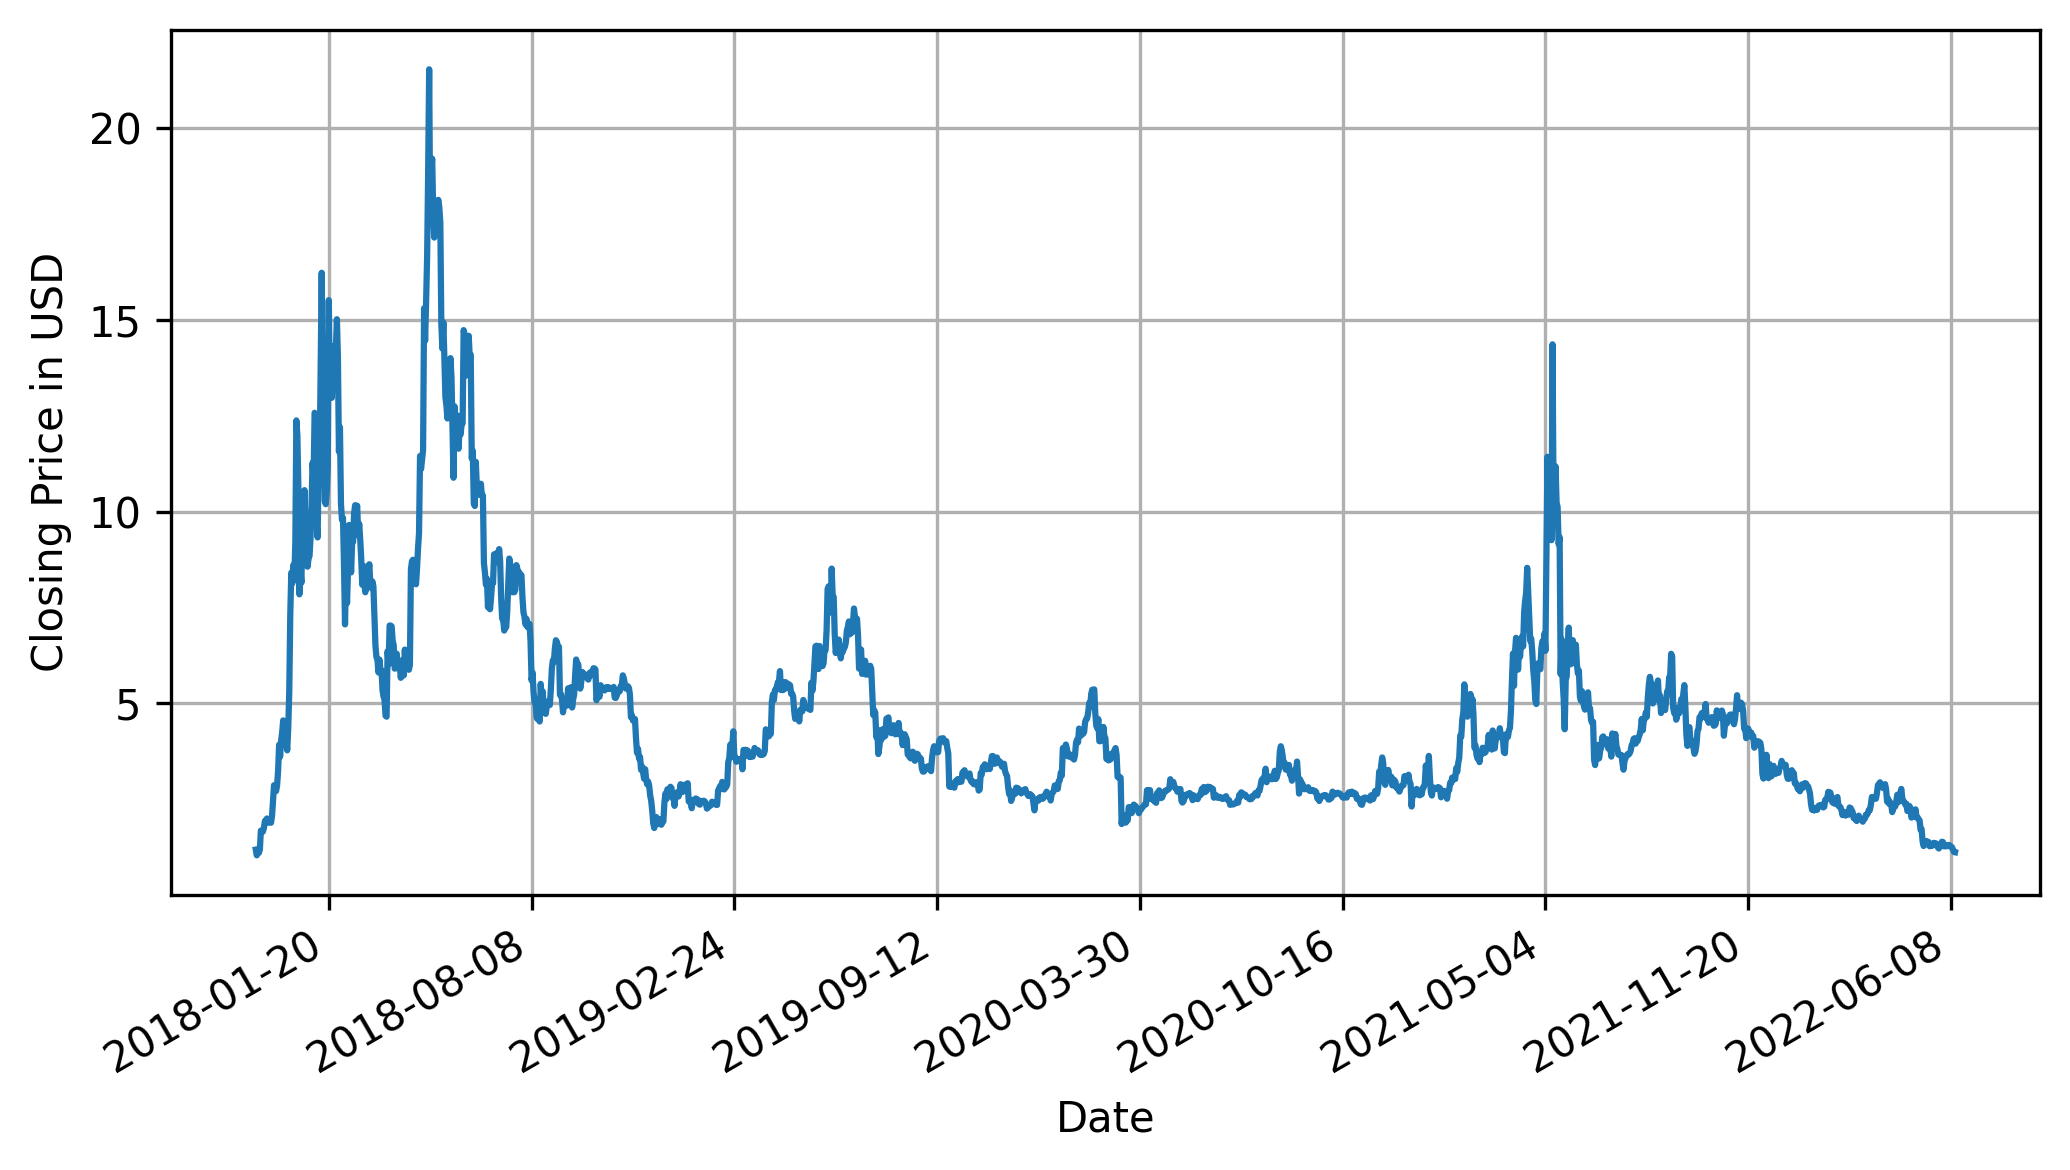

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1477 200
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 250)               252000    
                                 

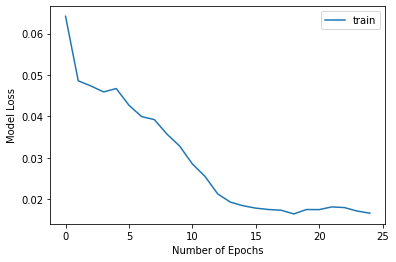

6/6 [==============================] - 0s 1ms/step


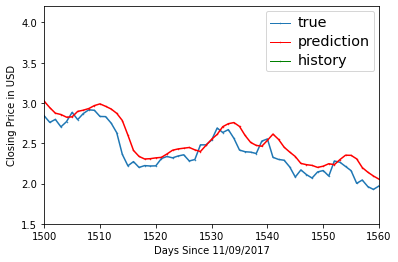

(190,)
(190, 1)
Root mean squared error EOS-USD: 0.17307915233672871
EOS-USD selected


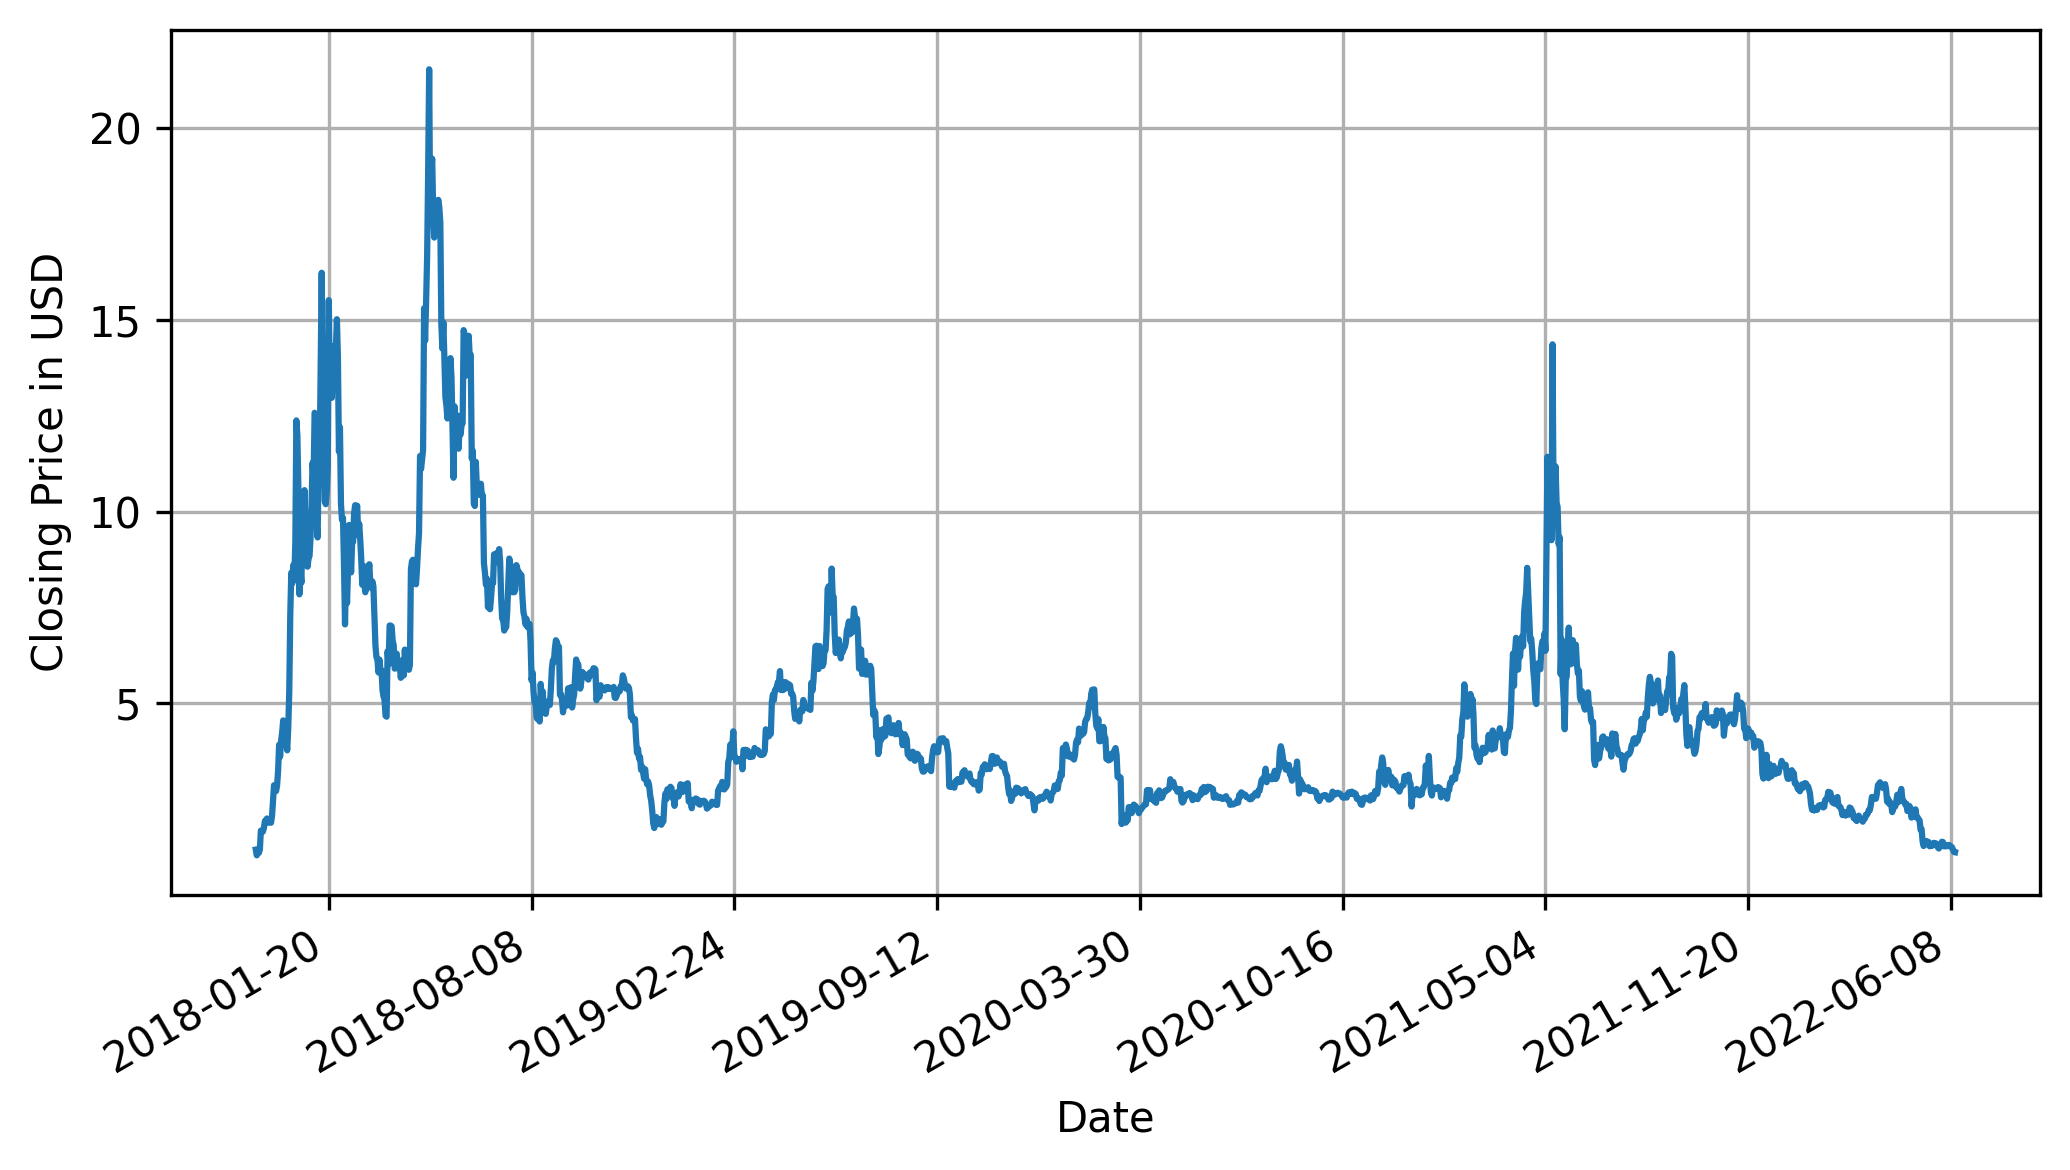

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1477 200
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 250)               252000    
                                 

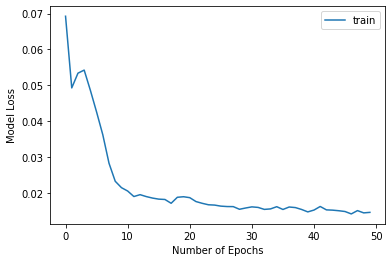

6/6 [==============================] - 0s 1ms/step


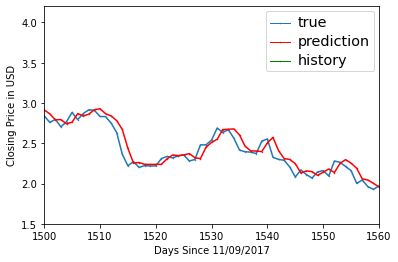

(190,)
(190, 1)
Root mean squared error EOS-USD: 0.12298999244756412
EOS-USD selected


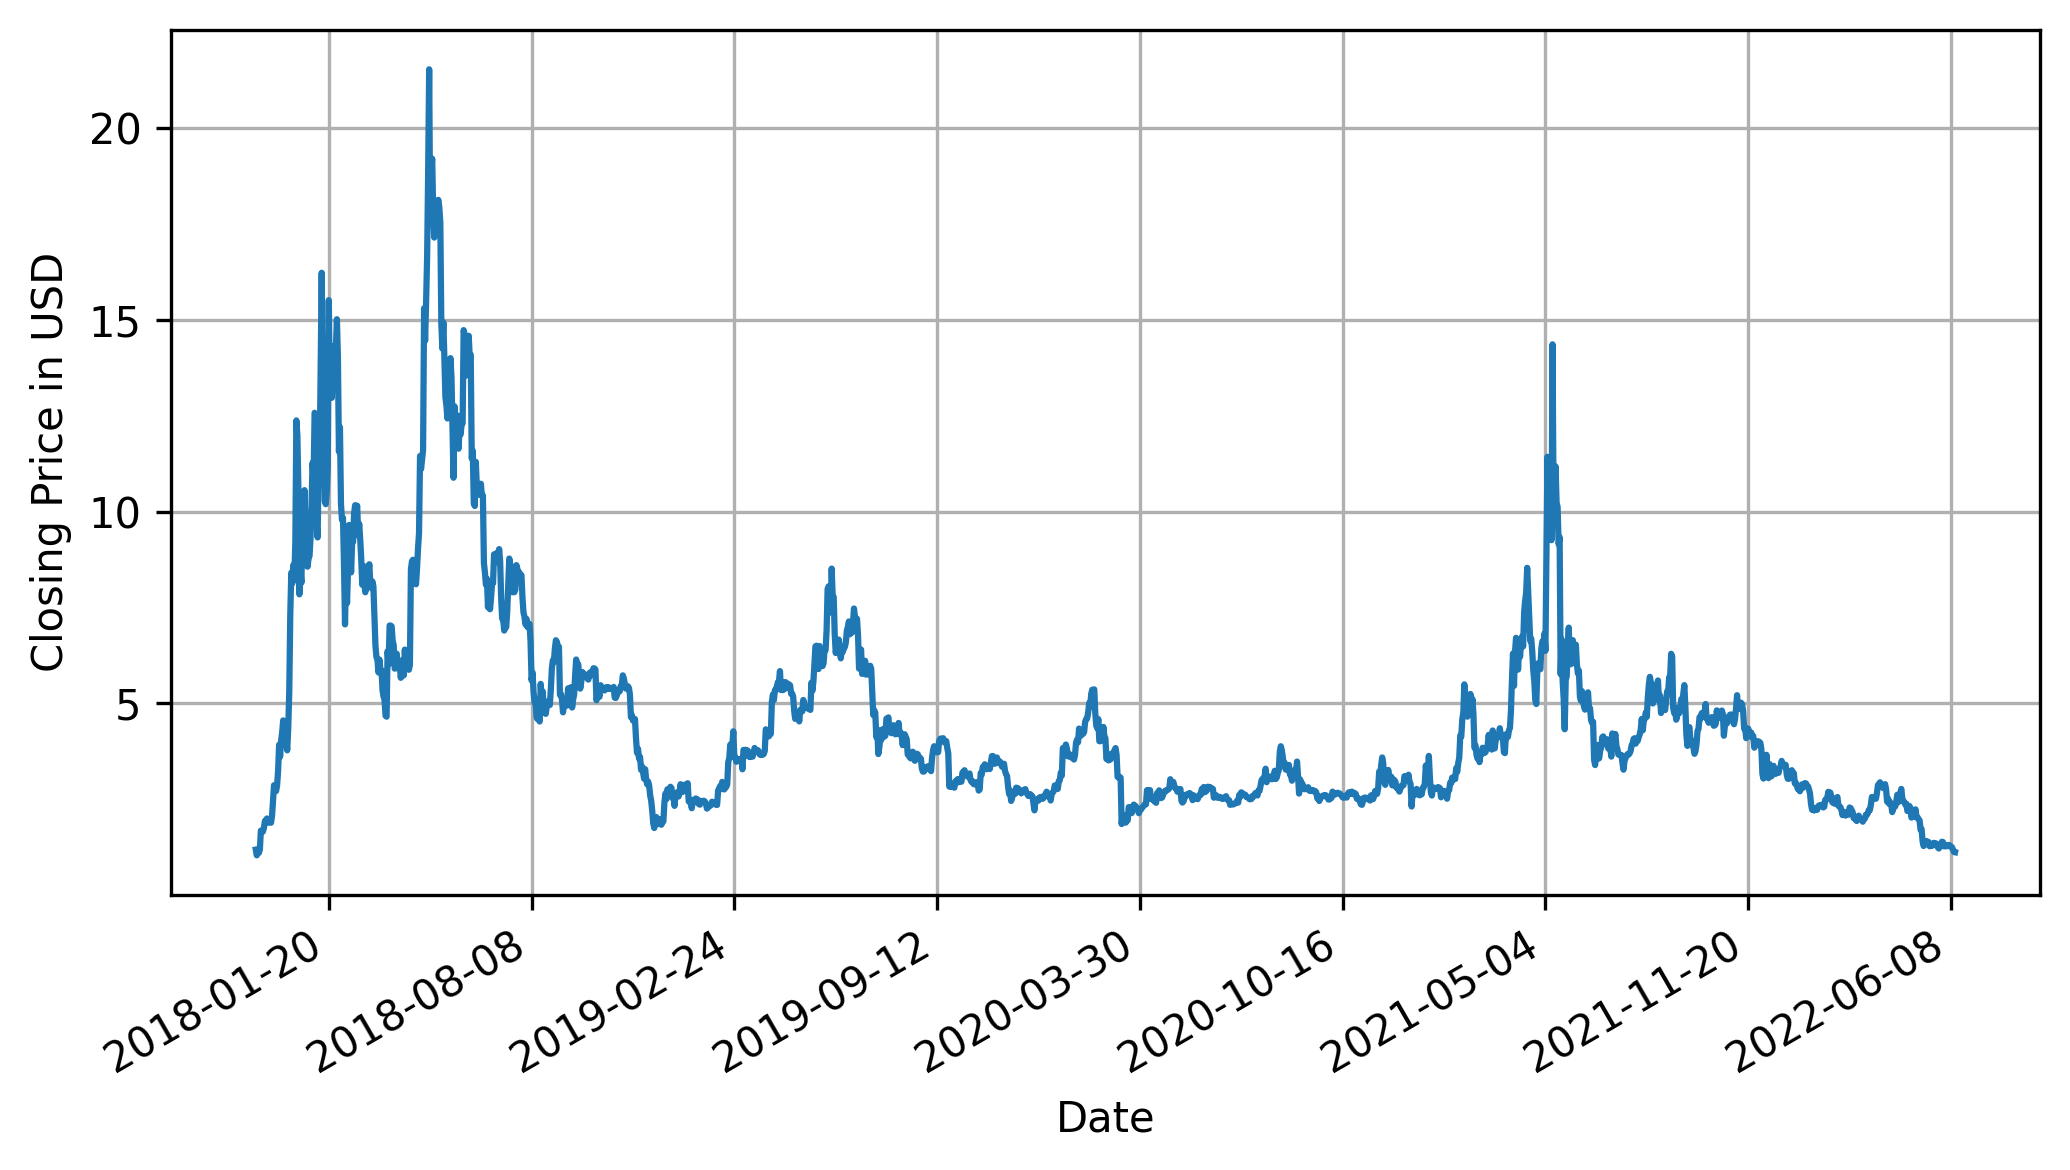

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1477 200
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 250)               252000    
                                 

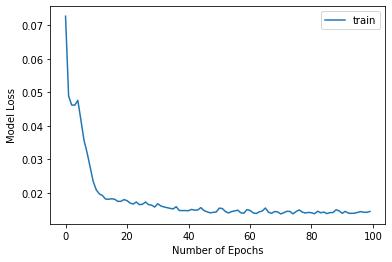

6/6 [==============================] - 0s 3ms/step


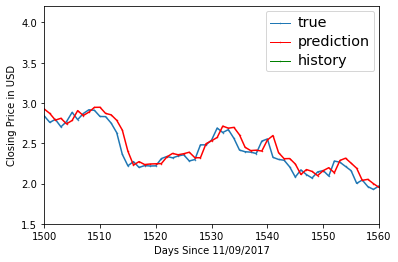

(190,)
(190, 1)
Root mean squared error EOS-USD: 0.12438560496225504
EOS-USD selected


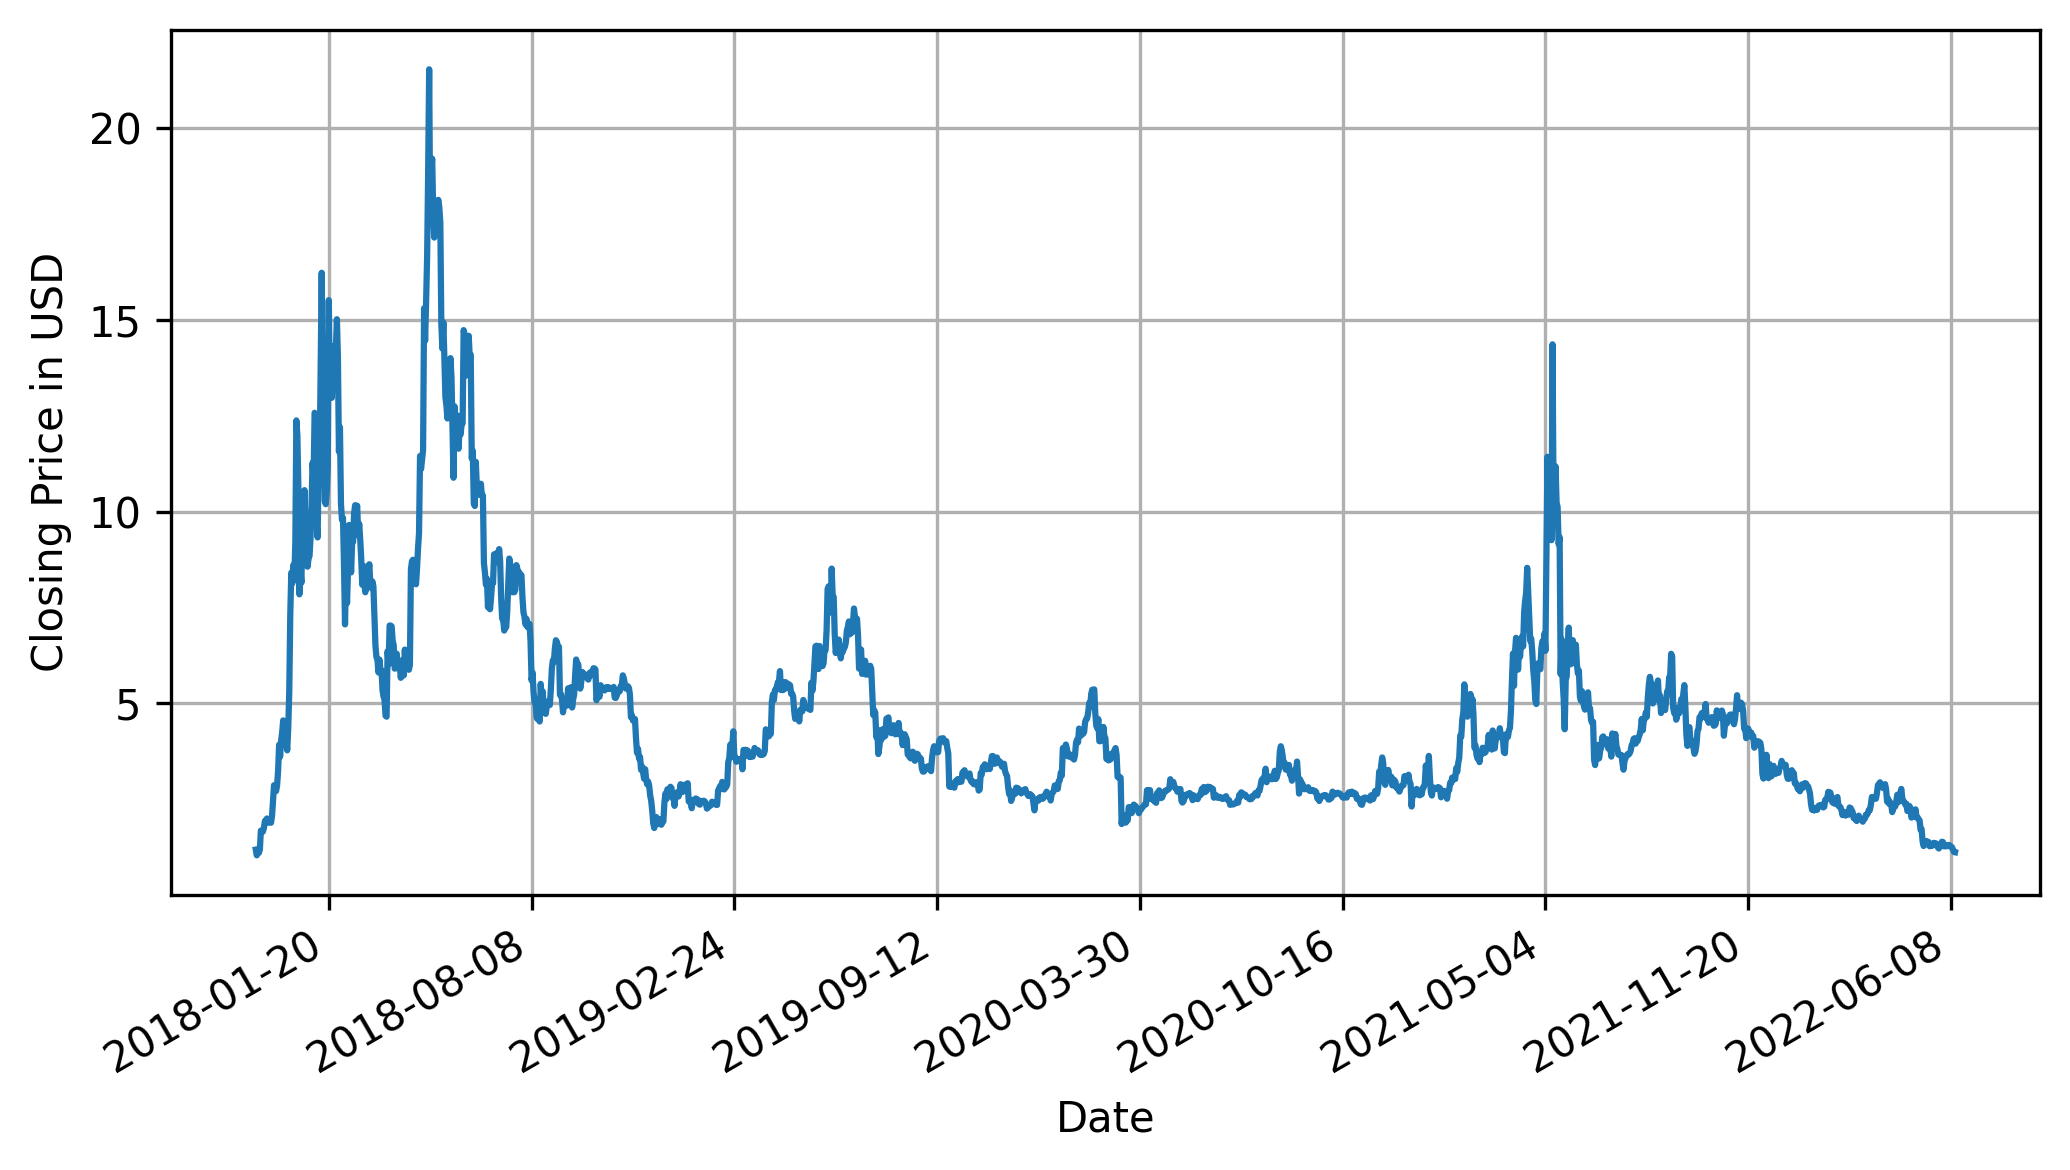

2017-11-09 00:00:00
2017-11-09 00:00:00
11/09/2017
               Open     High      Low    Close    Volume  Dividends  \
Date                                                                  
2017-11-09  1.13307  1.20771  1.13254  1.18080  24725800          0   
2017-11-10  1.18214  1.18214  0.99488  1.03065  23024200          0   
2017-11-11  1.02906  1.18155  1.01155  1.16498  27539300          0   
2017-11-12  1.15967  1.17923  1.03654  1.09397  29229800          0   
2017-11-13  1.09447  1.18850  1.08344  1.17888  20848600          0   

            Stock Splits  
Date                      
2017-11-09             0  
2017-11-10             0  
2017-11-11             0  
2017-11-12             0  
2017-11-13             0  
1477 200
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 250)               252000    
                                 

In [ ]:
list_of_cryptos = ["EOS-USD", "BTC-USD", "ETH-USD", "DOGE-USD"]
list_of_cryptos = ["EOS-USD"]

for epoch in epochs:
    for crypto in list_of_cryptos:
        lstm(crypto, epoch=epoch, output=config.debug)


In [ ]:

benchmark_filename = f"benchmarks/{config.user}-{config.node}.log"
StopWatch.benchmark(user=config.user, node=config.node, tag=crypto)
StopWatch.benchmark(filename=benchmark_filename, user=config.user, node=config.node, tag=crypto)
